In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from model import VAE

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
model = VAE(latent_dim=2)


train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=128, shuffle=True)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

<IPython.core.display.Javascript object>

Feature batch shape: torch.Size([128, 1, 28, 28])
Labels batch shape: torch.Size([128])


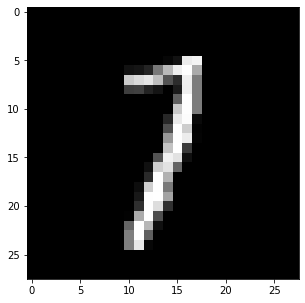

Label: 7


<IPython.core.display.Javascript object>

In [3]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
import torch.nn.functional as F
import torch.optim as optim

model.cuda()
# return reconstruction error + KL divergence losses
def criterion(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD
optimizer = optim.Adam(model.parameters())

<IPython.core.display.Javascript object>

In [5]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, mu, logvar = model(inputs)
        loss = criterion(outputs, inputs, mu, logvar)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')
    running_loss = 0.0
    # if epoch % 20 == 0:    # print every 2000 mini-batches
    #     plt.imshow(torchvision.utils.make_grid(inputs.cpu()).permute(1, 2, 0))
    #     plt.show()
        
    #     plt.imshow(torchvision.utils.make_grid(outputs.reshape((-1, 1, 28, 28)).cpu()).permute(1, 2, 0))
    #     plt.show()

print('Finished Training')

[1] loss: 23858.712
[2] loss: 21226.146
[3] loss: 20846.776
[4] loss: 20616.214
[5] loss: 20440.762
[6] loss: 20282.997
[7] loss: 20140.522
[8] loss: 20028.204
[9] loss: 19923.958
[10] loss: 19842.638
Finished Training


<IPython.core.display.Javascript object>

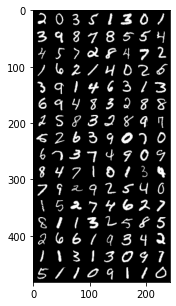

GroundTruth:  2     0     3     5     1     3     0     1     3     9     8     7     8     5     5     4    


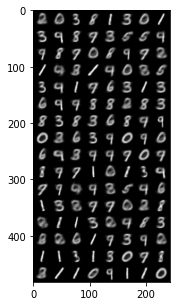

<IPython.core.display.Javascript object>

In [8]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
outputs, _, _ = model(images.cuda())
plt.imshow(torchvision.utils.make_grid(images.cpu()).permute(1, 2, 0))
plt.show()
plt.imshow(torchvision.utils.make_grid(outputs.reshape((-1, 1, 28, 28)).cpu()).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))